# 5002 Project

reference:  
https://github.com/Yorko/mlcourse.ai/tree/master/jupyter_english/topic09_time_series  
https://github.com/Yorko/mlcourse.ai/tree/master/jupyter_english/tutorials  
https://github.com/intellygenta/KDDCup2021  
https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html  


Backend architecture: Tensorflow    
packages need: stumpy

In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import plotly.graph_objs as go
#import plotly.offline as py
import seaborn as sns
from keras.layers import LSTM, Activation, Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

import datetime as dt
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import stumpy
from scipy import signal
import warnings

warnings.filterwarnings("ignore")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16031652388499339903
xla_global_id: -1
]


In [3]:
# set device GPU
tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

use_gpu = True
# Select stump function
if use_gpu:
    stump = stumpy.gpu_stump
else:
    stump = stumpy.stump

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Load Data

In [4]:
# Path setting
#rootpath = pathlib.Path('../data-sets/KDD-cup/data')
import pathlib
rootpath = pathlib.Path('../data-sets/KDD-Cup/data')
DS_store = rootpath/'.DS_Store'
txt_dirpath = rootpath  # Place the txt files in this directory

data = []
split = []

for txt_filepath in sorted(txt_dirpath.iterdir()):
    if txt_filepath == DS_store:
        continue
    # Load time series
    d = np.loadtxt(txt_filepath)
    number = txt_filepath.stem.split('_')[0]
    s = int(txt_filepath.stem.split('_')[-1])
    data.append(d)
    split.append(s)
    print(f'\n{txt_filepath.name} {s}/{len(d)}', flush=True)
print('done')


001_UCR_Anomaly_35000.txt 35000/79795

002_UCR_Anomaly_35000.txt 35000/80001

003_UCR_Anomaly_35000.txt 35000/80000

004_UCR_Anomaly_2500.txt 2500/11000

005_UCR_Anomaly_4000.txt 4000/8184

006_UCR_Anomaly_4000.txt 4000/8184

007_UCR_Anomaly_4000.txt 4000/8184

008_UCR_Anomaly_4000.txt 4000/8184

009_UCR_Anomaly_4000.txt 4000/8184

010_UCR_Anomaly_4000.txt 4000/8184

011_UCR_Anomaly_10000.txt 10000/30000

012_UCR_Anomaly_15000.txt 15000/30000

013_UCR_Anomaly_15000.txt 15000/30000

014_UCR_Anomaly_8000.txt 8000/30000

015_UCR_Anomaly_5000.txt 5000/200000

016_UCR_Anomaly_5000.txt 5000/30000

017_UCR_Anomaly_5000.txt 5000/30000

018_UCR_Anomaly_8000.txt 8000/30000

019_UCR_Anomaly_5000.txt 5000/12000

020_UCR_Anomaly_5000.txt 5000/12000

021_UCR_Anomaly_5000.txt 5000/12000

022_UCR_Anomaly_4000.txt 4000/12000

023_UCR_Anomaly_5000.txt 5000/12000

024_UCR_Anomaly_3200.txt 3200/7501

025_UCR_Anomaly_2800.txt 2800/7501

026_UCR_Anomaly_1700.txt 1700/7601

027_UCR_Anomaly_1200.txt 1200/750

# Data Preprocessing

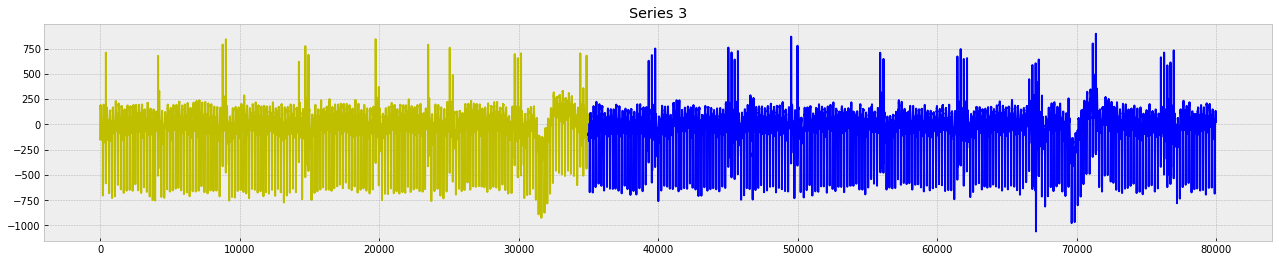

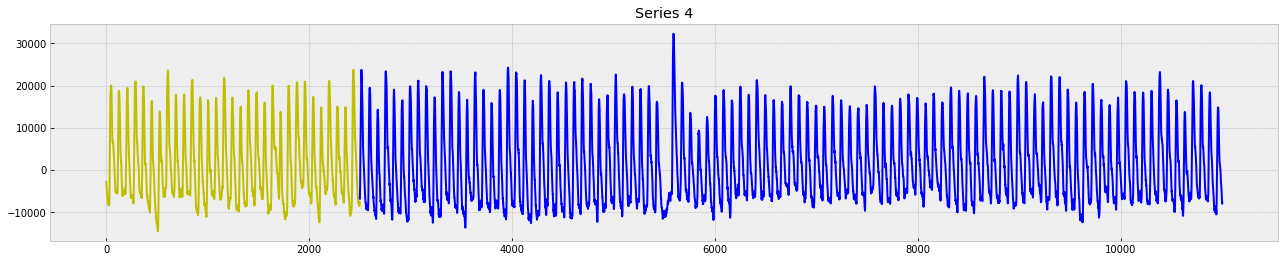

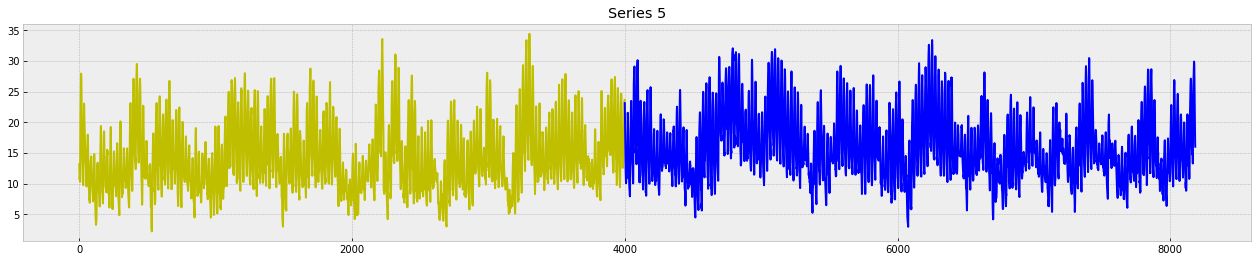

In [12]:
# plot original series
for i in range(2,5):
    with plt.style.context("bmh"):
        plt.rcParams['figure.figsize'] = (22.0, 4.0) 
        df = pd.DataFrame(data[i])
        plt.plot(df[0: split[i]], c='y')
        plt.plot(df[split[i]: len(df)], c='b')
        plt.title('Series %.d' % (i+1))
        plt.show()

In [ ]:
# define a exponential smoothing function for unstationary series
def exponential_smoothing(data, alpha):
    #alpha is the smoothing parameter
    result = [data[0]]  # first value is same as series
    for n in range(1, len(data)):
        result.append(alpha * data[n] + (1 - alpha) * result[n - 1])
    return result

In [ ]:
from statsmodels.tsa.stattools import adfuller

def smoothing(data):

    '''
        If the series is unstationary under Augmented Dicky-Fuller test,
        add the index of unstationary series to the unstationarylist
    '''
    unstationarylist = []
    for i in range(len(data)):
        adfresult = adfuller(data[i], autolag='AIC')
        if adfresult[1] > 0.05:
            unstationarylist.append(i)
        data1 = data

    '''
        For unstationary series,
        generate new series = exponential_smoothing series - original series.
        The new series is stationary.
        Replece the original series with the new series.
    '''
    for i in unstationarylist:
        smoothing_series = exponential_smoothing(series, alpha)
        data1[i] = data[i] - smoothing_series
    return data1

data1 = smoothing(data)

In [ ]:
# plot some unstationary series for visualization
"""
    Plots exponential smoothing with different alphas
    i: the index of original series
    alpha: the smoothing parameter
        
"""
def plotExponentialSmoothing(i, alpha):
    
    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(25, 7))
        smoothing_series = exponential_smoothing(data[i], alpha)
        plt.plot(smoothing_series, c='b', label='Smoothing: Alpha = %.2f' % alpha, linewidth=0.5)
        plt.plot(data[i], c="y", label="Actual", linewidth=0.5)
        plt.plot(smoothing_series - data[i], c='r', label='Difference', linewidth=0.5)
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing: Series %.d" % i)
        plt.grid(True)

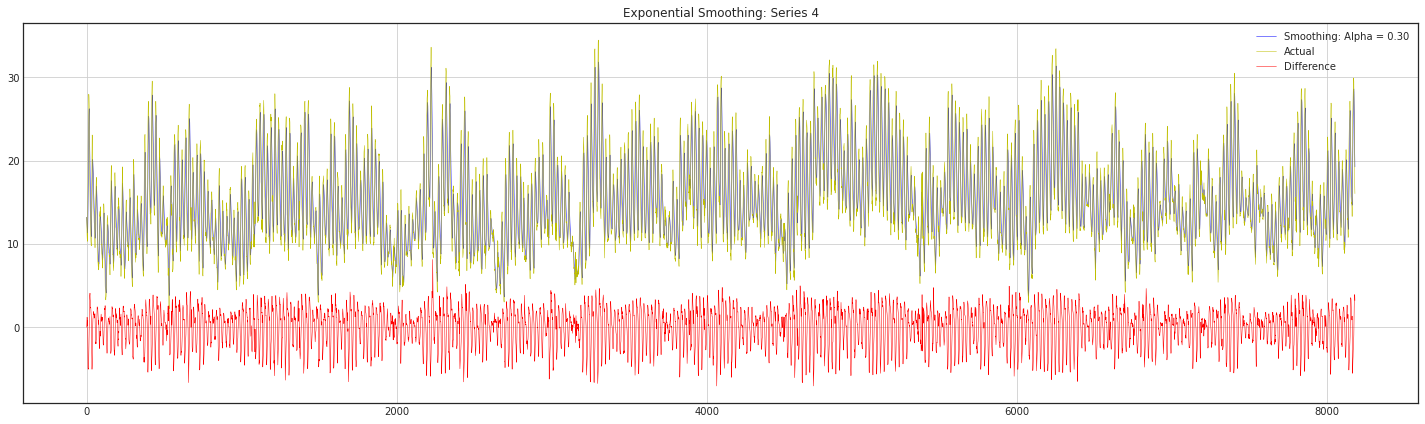

In [ ]:
"""
    Exponential smoothing processing visualization
"""

plotExponentialSmoothing(4, 0.3)

# 1. Matrix Profile

In [ ]:
"""
    From min to max get window size.
"""
min_window_size = 50
max_window_size = 800
growth_rate = 1.2
size = int(np.log(max_window_size / min_window_size) / np.log(growth_rate)) + 1
rates = np.full(size, growth_rate) ** np.arange(size)
ws = (min_window_size * rates).astype(int)

In [ ]:
"""
    Compute matrix profile value and index for each dataset in window size.
"""
def anomaly_score(X, w):

    res = pd.DataFrame()
    # matrix profile value (mpv) and index (mpi)
    mpv = {}
    mpi = {}
    mp = stump(X, w)
    mpv = mp[:, 0].astype(float)
    mpi = mp[:, 1].astype(int)
    res['mpi']= mpi
    res['mpv'] = mpv
    
 

In [ ]:
"""
    Compute matrix profile and use peak-to-peak algorithm.
"""
def MPcompute(X):
    highest_mp= 0
    highest_mp_index = 0
    highest_rate = 0
    # Evaluate anomaly score for each window size w
    for w in ws:
        #print(w)
        # Compute matrix profile
        mpscore = anomaly_score(X, w)
        y = mpscore['mpv']    
        # use peak to peak
        
        # Find 1st peak
        index1 = y.idxmax()
        value1 = y.max()

        # Skip if all score is NaN
        if not np.isfinite(value1):
            continue

        # Skip if train data has 1st peak
        begin = index1 - w
        end = index1 + w
        if begin < split:
            continue

        # Find 2nd peak
        y.iloc[begin:end] = np.nan
        index2 = y.idxmax()
        value2 = y.max()

        # Skip if 2nd peak height is zero
        if value2 == 0:
            continue

        # Evaluate rate of 1st peak height to 2nd peak height
        rate = value1 / value2
        
        if value1 > highest_mp and rate> highest_rate:
            highest_mp = value1
            highest_mp_index = index1
            highest_rate = rate
            #print(value1,index1,highest_rate)
        
    return highest_mp_index

In [ ]:
"""
  Compute Matrix profile
"""
mpresults = []

for i in range(70,250):
    x = data[i]
    #split = splits[i]
    #print(i,split)
    res = MPcompute(x)
    print(res)
    mpresults.append(res)

# 2. LSTM

In [15]:
"""
 Making a function to break data, scale data, window data
"""
def get_window_data(data, window):
    # Get window data and scale
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data.reshape(-1, 1))

    X = []
    y = []

    for i in range(len(data) - window - 1):
        X.append(data[i : i + window])
        y.append(data[i + window + 1])

    X = np.asarray(X)
    y = np.asarray(y)
    return X, y, scaler

In [16]:
from keras.layers import LSTM, Activation, Dense, Dropout
from keras.models import Sequential

"""
 Building the LSTM model:
 parameters settings: 50neurons, and and window_size = 50
"""
window_size = 50
model = Sequential()
 
model.add(LSTM(50, input_shape=(window_size, 1)))  
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")


In [27]:
"""
  Train model
"""

indexlist = []
histlist = []
plotlist = []

for i in range(249,250):

  # get train and test data
  
    X, y, scaler = get_window_data(data[i], window_size)

    test_split = split[i]

    X_train = X[:test_split]
    X_test = X[test_split:]
    y_train = y[:test_split]
    y_test = y[test_split:]

    print('------ Series %.d ------' % (i+1))

    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    # fit the model
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=10,
    callbacks=[callback],
    validation_data=(X_test, y_test),
    verbose=2,
    shuffle=False,
    )

    histlist.append(history)

    # MSE for LSTM
    mse_lstm = mean_squared_error(
    scaler.inverse_transform(y_test), scaler.inverse_transform(model.predict(X_test))
    )
    mse_lstm = np.sqrt(mse_lstm)
    #print("RMSE for LSTM {:.2f}".format(mse_lstm))



    # find the most anomalous point
    pred = model.predict(X_test)
    pred_inverse = scaler.inverse_transform(pred.reshape(-1, 1))
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

    # MSE for test set
    mse_test = sqrt(mean_squared_error(y_test_inverse, pred_inverse))

    diff = abs(pred_inverse - y_test_inverse)
    index = np.argmax(diff) + split[i]

    plotlist.append([pred_inverse, y_test_inverse, index-split[i], i+1])

    print('The index of most anomalous point: %.d' % index)
    print('\n')

    indexlist.append([index, mse_lstm, mse_test])

results = pd.DataFrame(indexlist, columns=['index', 'mse_lstm', 'mse_test'])

------ Series 250 ------
Epoch 1/20
296/296 - 11s - loss: 0.0239 - val_loss: 0.0103 - 11s/epoch - 38ms/step
Epoch 2/20
296/296 - 10s - loss: 0.0155 - val_loss: 0.0090 - 10s/epoch - 35ms/step
Epoch 3/20
296/296 - 10s - loss: 0.0139 - val_loss: 0.0084 - 10s/epoch - 35ms/step
Epoch 4/20
296/296 - 10s - loss: 0.0125 - val_loss: 0.0070 - 10s/epoch - 35ms/step
Epoch 5/20
296/296 - 11s - loss: 0.0112 - val_loss: 0.0059 - 11s/epoch - 36ms/step
Epoch 6/20
296/296 - 11s - loss: 0.0097 - val_loss: 0.0054 - 11s/epoch - 38ms/step
Epoch 7/20
296/296 - 10s - loss: 0.0094 - val_loss: 0.0050 - 10s/epoch - 33ms/step
Epoch 8/20
296/296 - 10s - loss: 0.0087 - val_loss: 0.0048 - 10s/epoch - 35ms/step
Epoch 9/20
296/296 - 10s - loss: 0.0082 - val_loss: 0.0047 - 10s/epoch - 35ms/step
Epoch 10/20
296/296 - 10s - loss: 0.0081 - val_loss: 0.0046 - 10s/epoch - 34ms/step
Epoch 11/20
296/296 - 10s - loss: 0.0079 - val_loss: 0.0045 - 10s/epoch - 35ms/step
Epoch 12/20
296/296 - 10s - loss: 0.0074 - val_loss: 0.0046 

In [ ]:
indexlist

In [31]:
"""
  For some seires, make functions for plotting history and predictions

"""
def plot_history(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Test")
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def plottestset():
    # plot predieted value, actual value and the anomaly
    pred_inverse = plotlist[0][0]
    y_test_inverse = plotlist[0][1]
    index = plotlist[0][2]

    plt.figure(figsize=(15, 8))
    plt.plot(pred_inverse, c='y', label="predict")
    plt.plot(y_test_inverse, c='b', label="actual")
    plt.axvline(index, color='k', linestyle='dashed')
    plt.title('Series %.d (test set plot only)' % plotlist[0][3])
    plt.legend()
    plt.show()

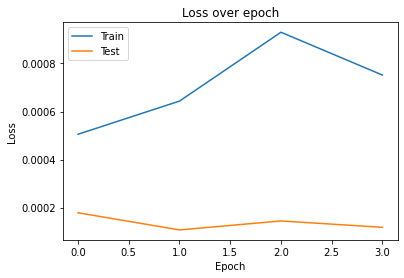

In [19]:
plot_history(histlist[0])

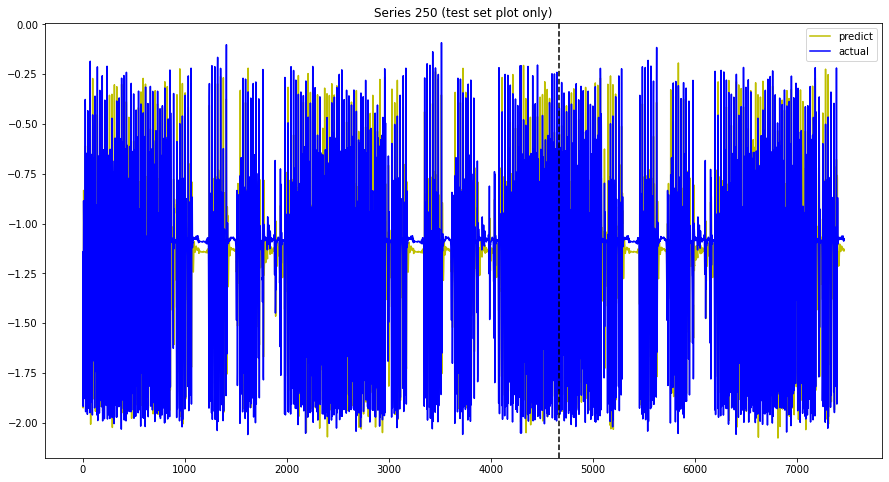

In [32]:
plottestset()

# Hybrid Results

In [ ]:
"""
  For results, we generate the final results from 2 models' results.
  Futhur operation details please refer to our report.
"""
hybrid_res = [mpresults,indexlist]
df = pd.DataFrame(hybrid_res).T
df.to_csv('result.csv')